In [ ]:
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [60]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')


In [5]:
pytrends = TrendReq(hl='en-US', tz=360)

In [6]:
kw_list = ['job']
pytrends.build_payload(kw_list, cat=0, timeframe='2005-01-01 2018-12-31', geo='US', gprop='')

In [7]:
df_job = pytrends.interest_over_time()

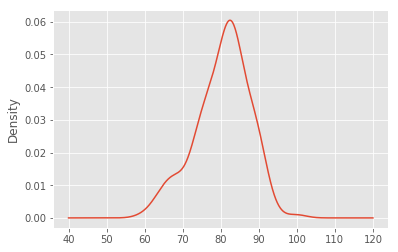

In [8]:
df_job.job.plot.kde()

In [73]:
df_job.index

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=168, freq=None)

In [12]:
df_job.drop("isPartial",inplace=True,axis=1)

In [20]:
df_job_array = df_job.values

In [25]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [27]:
df_supervised = timeseries_to_supervised(df_job)

In [43]:
# stationarize data
def return_seasonal_decomp(data):
    decomposition = seasonal_decompose(data)

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(data, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout()
    return decomposition

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


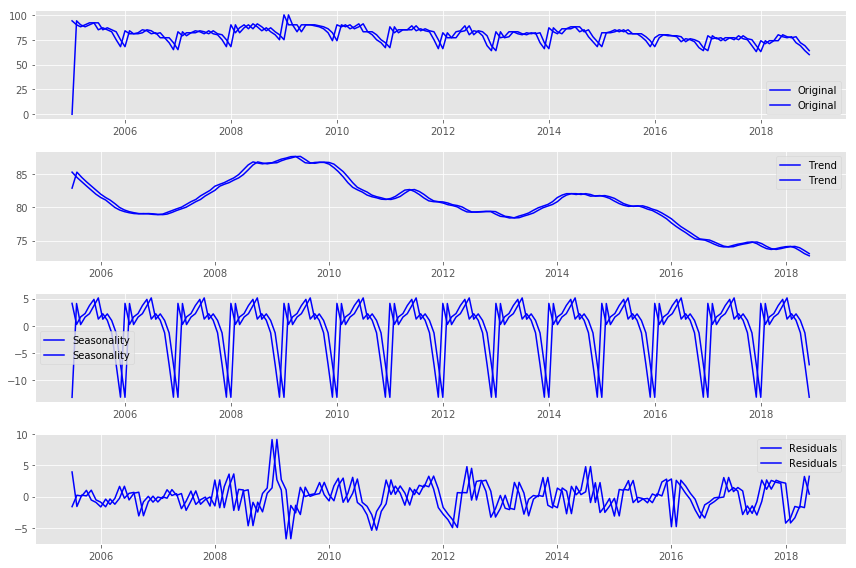

In [64]:
df_stat = return_seasonal_decomp(df_supervised)

In [65]:
df_resid = df_stat.resid.dropna()

In [66]:
X = df_resid.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
df_resid_scaled = scaler.transform(X)

ValueError: cannot reshape array of size 312 into shape (156,1)

In [62]:
df_resid_scaled

array([[ 0.344123  ],
       [-0.35140603],
       [-0.12158608],
       [-0.1381752 ],
       [-0.02286061],
       [-0.21747926],
       [-0.26562816],
       [-0.3570706 ],
       [-0.20008092],
       [-0.30568481],
       [-0.18470564],
       [ 0.05644346],
       [-0.2186931 ],
       [-0.08314789],
       [-0.06372648],
       [-0.53793243],
       [-0.25429901],
       [-0.14383977],
       [-0.2603682 ],
       [-0.15719199],
       [-0.18430103],
       [-0.01112685],
       [-0.12684604],
       [-0.09083552],
       [-0.42909164],
       [-0.24094679],
       [-0.03742666],
       [-0.30649403],
       [-0.2122193 ],
       [-0.15961966],
       [-0.33926765],
       [ 0.18470564],
       [-0.37365972],
       [ 0.05199272],
       [ 0.30447097],
       [-0.42747319],
       [-0.03985434],
       [-0.01476836],
       [-0.73700182],
       [-0.26441432],
       [-0.45943759],
       [-0.08598017],
       [ 0.02366984],
       [ 1.        ],
       [ 0.18915638],
       [-0

In [63]:
#reverse MinMaxScaling
# inverted_X = scaler.inverse_transform(df_resid_scaled)

In [75]:
# Full Code
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# Load Dataset

# Convert to supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = data
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# Stationarize data
def difference(data):
    decomposition = seasonal_decompose(data)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return decomposition

# Undo Stationarization
def invert_difference(decomp, yhat):
	return yhat + decomp.seasonal + decomp.trend

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = df_job

# transform data to be stationary
## raw_values = series.values
diff_values = difference(series)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# # split data into train and test-sets
# train, test = supervised_values[0:-12], supervised_values[-12:]

# # transform the scale of the data
# scaler, train_scaled, test_scaled = scale(train, test)

# # fit the model
# lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# # forecast the entire training dataset to build up state for forecasting
# train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# lstm_model.predict(train_reshaped, batch_size=1)

# # walk-forward validation on the test data
# predictions = list()
# for i in range(len(test_scaled)):
# 	# make one-step forecast
# 	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
# 	yhat = forecast_lstm(lstm_model, 1, X)
# 	# invert scaling
# 	yhat = invert_scale(scaler, X, yhat)
# 	# invert differencing
# 	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
# 	# store forecast
# 	predictions.append(yhat)
# 	expected = raw_values[len(train) + i + 1]
# 	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# # report performance
# rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
# print('Test RMSE: %.3f' % rmse)
# # line plot of observed vs predicted
# pyplot.plot(raw_values[-12:])
# pyplot.plot(predictions)
# pyplot.show()

AttributeError: 'DecomposeResult' object has no attribute 'shift'